### Baby sleep data analysis

Since our baby was born one thing that has helped us to better understand and anticipate his needs has been to manually track his activities, mostly sleeping, feeding and diaper changing. The app I use, Baby Tracker, provides basic tracking (i.e. activity type, start time and end time) without any insights.

In his 3rd month I thought it could be interesting to do some exploratory analysis on the data I had been collecting to see if there were any interesting patterns  that could shed some light on the future of our sleep. Eventually this analysis has helped me to better understand his journey in learning how to sleep, a journey which is not over yet.

This notebook includes the analysis of his sleep data.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, time, date, timedelta
# import calendar

# for smoothing line plots
from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from dateutil import tz

SpanishTZ = tz.gettz('Europe/Madrid')

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Preprocessing <a class="anchor" id="sec_preproc"></a>

### Importing and cleaning the JSON file <a class="anchor" id="importing_data"></a>

The app data is in Realm format. You can upload a backup from a given date to your iCloud. [Realm Studio](realm.io) allows you to export the data in JSON format.

In [5]:
file_date = date(2022,12,8) 

# will later use this to filter the records
START_DATE = date(2022,6,15) 
END_DATE = date(2022,12,1) 

In [6]:
import json

filename = "gdrive/My Drive/Colab Notebooks/data/baby/my_baby_tracker_{}-{}-{}.json".format(file_date.day, file_date.month, file_date.year)

f = open(filename)

json_obj = json.load(f)

In [7]:
json_obj.keys()

dict_keys(['BabyItem', 'EventItem', 'FavoritesSettings', 'HealthItem', 'MeasureSettings'])

The key we are interested in is `EventItem` which contains a list of tracked events including feeding, sleeping and diaper chaning events.

This list can then be easily converted to a Pandas DataFrame for easier data analysis.

In [8]:
event_item = json_obj["EventItem"]
type(event_item)

list

In [9]:
len(event_item)

2959

In [10]:
event_item[0]

{'id': 'A1523E07-BD25-4A77-806F-51CBE9DAA3C4',
 'babyId': 'DB25FFEF-9BCE-4730-B464-B166A0BB4579',
 'comment': '',
 'photo': None,
 'type': 'sleep',
 'enteredDate': '2022-06-15T06:30:25.000Z',
 'customComment': '',
 'leftStart': '2022-06-15T04:50:25.000Z',
 'leftEnd': '2022-06-15T06:30:25.000Z',
 'rightStart': None,
 'rightEnd': None,
 'leftSeconds': 0,
 'rightSeconds': 0,
 'mixType': '',
 'bottleAmount': '',
 'bottleAmountOunce': '',
 'weight': '',
 'height': '',
 'headCirc': '',
 'temperature': '',
 'weightPounds': '',
 'heightInches': '',
 'headCircInches': '',
 'temperatureFah': '',
 'breast': '',
 'singleTimerStart': None,
 'singleTimerSeconds': 6000,
 'doubleLeftTimerStart': None,
 'doubleRightTimerStart': None,
 'doubleLeftTimerSeconds': None,
 'doubleRightTimerSeconds': None}

In [11]:
df = pd.DataFrame(event_item)
print(df.shape)

(2959, 31)


In [12]:
df.isna().sum()

id                            0
babyId                        0
comment                       0
photo                      2959
type                          0
enteredDate                   0
customComment                 0
leftStart                   740
leftEnd                     740
rightStart                 2959
rightEnd                   2959
leftSeconds                   0
rightSeconds                  0
mixType                       0
bottleAmount                  0
bottleAmountOunce             0
weight                        0
height                        0
headCirc                      0
temperature                   0
weightPounds                  0
heightInches                  0
headCircInches                0
temperatureFah                0
breast                        0
singleTimerStart           2959
singleTimerSeconds         1882
doubleLeftTimerStart       2959
doubleRightTimerStart      2959
doubleLeftTimerSeconds     2959
doubleRightTimerSeconds    2959
dtype: i

In [13]:
# drop all columns where ALL values are empty (how='all', by default how='any')
df = df.dropna(how='all', axis=1)
print(df.shape)
df.head()

(2959, 23)


,id,babyId,comment,type,enteredDate,customComment,leftStart,leftEnd,leftSeconds,rightSeconds,...,weight,height,headCirc,temperature,weightPounds,heightInches,headCircInches,temperatureFah,breast,singleTimerSeconds
0,A1523E07-BD25-4A77-806F-51CBE9DAA3C4,DB25FFEF-9BCE-4730-B464-B166A0BB4579,,sleep,2022-06-15T06:30:25.000Z,,2022-06-15T04:50:25.000Z,2022-06-15T06:30:25.000Z,0,0,...,,,,,,,,,,6000.0
1,55EA0261-C40F-4759-AA5F-1280790A9993,DB25FFEF-9BCE-4730-B464-B166A0BB4579,,lactation,2022-06-15T05:00:46.000Z,,2022-06-15T05:00:46.000Z,2022-06-15T06:30:46.000Z,0,0,...,,,,,,,,,right,NaN
2,DB4C539A-9471-42B8-8C64-AD2154312414,DB25FFEF-9BCE-4730-B464-B166A0BB4579,,lactation,2022-06-15T03:00:21.000Z,,2022-06-15T03:00:21.000Z,2022-06-15T04:45:21.000Z,0,0,...,,,,,,,,,left,NaN
3,CA7688BB-98C5-4885-AA37-140CDFDD3064,DB25FFEF-9BCE-4730-B464-B166A0BB4579,,diaper,2022-06-15T00:00:51.000Z,wet,None,None,0,0,...,,,,,,,,,,NaN
4,22916A2A-9BE2-48B2-8F7D-C410FD01DC17,DB25FFEF-9BCE-4730-B464-B166A0BB4579,,diaper,2022-06-15T04:40:30.000Z,wet,None,None,0,0,...,,,,,,,,,,NaN


In [14]:
# filter desired columns
columns_to_select = ['type', 'enteredDate', 'comment', 'customComment', 'mixType', 
                     'bottleAmount', 'weight', 'height', 
                     'breast', 'leftStart',	'leftEnd', 'singleTimerSeconds']

df = df[columns_to_select]
print(df.shape)
df.head()

(2959, 12)


,type,enteredDate,comment,customComment,mixType,bottleAmount,weight,height,breast,leftStart,leftEnd,singleTimerSeconds
0,sleep,2022-06-15T06:30:25.000Z,,,,,,,,2022-06-15T04:50:25.000Z,2022-06-15T06:30:25.000Z,6000.0
1,lactation,2022-06-15T05:00:46.000Z,,,,,,,right,2022-06-15T05:00:46.000Z,2022-06-15T06:30:46.000Z,NaN
2,lactation,2022-06-15T03:00:21.000Z,,,,,,,left,2022-06-15T03:00:21.000Z,2022-06-15T04:45:21.000Z,NaN
3,diaper,2022-06-15T00:00:51.000Z,,wet,,,,,,None,None,NaN
4,diaper,2022-06-15T04:40:30.000Z,,wet,,,,,,None,None,NaN


### Feature engineering

Add some additional columns for the analysis, such as:

* Calculate duration in hours
* Extract day, month and week number in baby life (i.e. starts at 1)
* Tag events with night or day as I want to analyse those separately

I consider "night hours" to be from 8pm (the earliest he goes to sleep and sleeps for a long time, i.e. at least 2h) until 10am (the latest he can get out of bed).


In [15]:
from pandas.core.arrays.datetimelike import NaT

# some activities like diaper changes don't have a start or end time, in that case use 
# the enteredDate which is not as accurate since sometimes I added it time later 
df['leftStart'] = df['leftStart'].fillna(df['enteredDate'])
df['leftEnd'] = df['leftEnd'].fillna(df['enteredDate'])

df['startTime'] = pd.to_datetime(df['leftStart']).dt.tz_convert(SpanishTZ)
df['endTime'] = pd.to_datetime(df['leftEnd']).dt.tz_convert(SpanishTZ)
df["date"] = df["startTime"].apply(lambda ts: ts.date() if ts is not pd.NaT else None)

<ipython-input-15-ae639e99b2c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leftStart'] = df['leftStart'].fillna(df['enteredDate'])
<ipython-input-15-ae639e99b2c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leftEnd'] = df['leftEnd'].fillna(df['enteredDate'])
<ipython-input-15-ae639e99b2c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [16]:
# Clean up. 

# We no longer need these columns
cols_to_drop = ['leftStart', 'leftEnd'] #, 'singleTimerSeconds']
df = df.drop(cols_to_drop, axis=1)

# Filter the first day which is incomplete and 1st day of December 
# (I only included it to consider the night of the 30th Nov).
df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]
df.shape

(2859, 13)

In [17]:
df["duration"] = (df['endTime'] - df['startTime'])
df["durationInMins"] = df["duration"].apply(lambda d: d.total_seconds()/60) 
df["durationInHours"] = df["duration"].apply(lambda d: d.total_seconds()/3600)

# baby's month and week number
min_date = df["startTime"].min()
first_week = min_date.weekofyear

df["week"] = df["startTime"].apply(lambda d: (d.weekofyear - first_week + 1) if d is not None else None)
df["month"] = df["startTime"].apply(lambda d: (d.month - min_date.month + 1) if d is not None else None)
df["day"] = df["startTime"].apply(lambda d: (d.dayofyear - min_date.dayofyear + 1) if d is not None else None)

<ipython-input-17-c5c010cb0f37>:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df["startTime"].apply(lambda d: (d.weekofyear - first_week + 1) if d is not None else None)


In [18]:
def to_decimal_hour(dt, n_decimals=1):
  dh = dt.hour + (dt.minute / 60) + (dt.second / 3600)
  return round(dh, n_decimals)

# extract hour of day as integer and as decimal
df["hour"] = df["startTime"].apply(lambda d: d.hour if d is not None else None)
df["decimalHour"] = df["startTime"].apply(lambda d: to_decimal_hour(d) if d is not None else None)
df["hourEnd"] = df["endTime"].apply(lambda d: d.hour if d is not None else None)

In [19]:
START_TIME = time(19, 0)
END_TIME = time(10, 0)

def time_of_day(start_time):
  if start_time is not pd.NaT:
    if (start_time.time() >= START_TIME) or (start_time.time() <= END_TIME): 
      return "night"
    else:
      return "day"
  else:
    return None

def night_date(start_time):
  """ 
    Returns the date this night hour is part of.
    e.g. 2022-08-11 at 04:00 this is actually part of the night of 2022-08-10,
    whereas at 21:00 is part of the same date.
    If the hour is not a night hour returns the same date.
  """
  if start_time is not pd.NaT:
    if (start_time.time() >= START_TIME): 
      return start_time.date()
    elif start_time.time() <= END_TIME:
      return (start_time - timedelta(days=1)).date()
    else:
      return start_time.date()
  else:
    return pd.NaT

df["timeOfDay"] = df["startTime"].apply(lambda st: time_of_day(st))
df["nightDate"] = df["startTime"].apply(lambda st: night_date(st))

In [20]:
cols = ["type", "startTime", "endTime", "date", "month", "hour", "decimalHour", "timeOfDay", "nightDate"]
df[cols].head(4)

,type,startTime,endTime,date,month,hour,decimalHour,timeOfDay,nightDate
0,sleep,2022-06-15 06:50:25+02:00,2022-06-15 08:30:25+02:00,2022-06-15,1,6,6.8,night,2022-06-14
1,lactation,2022-06-15 07:00:46+02:00,2022-06-15 08:30:46+02:00,2022-06-15,1,7,7.0,night,2022-06-14
2,lactation,2022-06-15 05:00:21+02:00,2022-06-15 06:45:21+02:00,2022-06-15,1,5,5.0,night,2022-06-14
3,diaper,2022-06-15 02:00:51+02:00,2022-06-15 02:00:51+02:00,2022-06-15,1,2,2.0,night,2022-06-14


### Aggregated dataset

Build DS with date and month aggregations.

In [21]:
selected_columns = ['type', 'date', 'day', 'startTime', 'endTime', 'duration',
       'durationInMins', 'durationInHours', 'month', 'week', 
       'hour', 'hourEnd', 'decimalHour', 'timeOfDay', 'nightDate']

df = df[selected_columns]

In [22]:
sleep_df = df[df["type"] == "sleep"]

day_sleep_df = sleep_df[sleep_df["timeOfDay"] == "day"]
night_sleep_df = sleep_df[sleep_df["timeOfDay"] == "night"]

In [23]:
# info on ALL naps aggregated by date
sleep_by_date = sleep_df.groupby(["date", "day", "week", "month"]).agg(num_naps=('date', 'count'),
                                                        total_sleep_time=('durationInHours', 'sum'),
                                                        mean_nap_time=('durationInHours', 'mean'),
                                                        max_nap_duration=('durationInHours', 'max'),
                                                        median_nap_time=('durationInHours', 'median')
                                                        ).reset_index()
# info on DAY naps aggregated by date
day_naps_by_date = day_sleep_df.groupby(["date"]).agg(num_day_naps=('date', 'count'), 
                                                      avg_day_nap_duration=('durationInHours', 'mean'),
                                                      median_day_nap_duration=('durationInHours', 'median'),
                                                      max_day_nap_duration=('durationInHours', 'max'),
                                                      total_day_sleep_time=('durationInHours', 'sum')
                                                      ).reset_index()

# info on NIGHT naps aggregated by date
night_naps_by_date = night_sleep_df.groupby(["nightDate", "month"]).agg(num_night_naps=('nightDate', 'count'), 
                                                          avg_night_nap_duration=('durationInHours', 'mean'),
                                                          median_night_nap_duration=('durationInHours', 'median'),
                                                          max_night_nap_duration=('durationInHours', 'max'),
                                                          total_night_sleep_time=('durationInHours', 'sum')
                                                          ).reset_index()

# # info on NIGHT naps aggregated by month                                                                      
# night_naps_by_month = night_sleep_df.groupby(["month", "month_name"]).agg(avg_night_nap_duration=('durationInHours', 'mean'),
#                                                                           median_night_nap_duration=('durationInHours', 'median'),
#                                                                           total_night_sleep_time=('durationInHours', 'sum')
#                                                                           ).reset_index().sort_values("month") #, ascending=False)

# bedtime by date and month
sleep_time = night_sleep_df[(night_sleep_df["durationInHours"] > 2) & 
                            (night_sleep_df["hour"] >= 19)].groupby(["nightDate", "month"])["hour"].min().reset_index()


# rename columns
night_naps_by_date = night_naps_by_date.rename({"nightDate": "date"}, axis=1)

sleep_time = sleep_time.rename({"hour": "sleep_hour", 
                                "nightDate": "date"}, axis=1)



In [24]:
# produce final DataFrame
activity_df = sleep_by_date.merge(day_naps_by_date, how="outer", on="date")\
                           .merge(night_naps_by_date, how="outer", on="date")\
                           .merge(sleep_time.drop("month", axis=1), how="outer", on="date")
                                                                              
activity_df.head(2)

,date,day,week,month_x,num_naps,total_sleep_time,mean_nap_time,max_nap_duration,median_nap_time,num_day_naps,...,median_day_nap_duration,max_day_nap_duration,total_day_sleep_time,month_y,num_night_naps,avg_night_nap_duration,median_night_nap_duration,max_night_nap_duration,total_night_sleep_time,sleep_hour
0,2022-06-15,1.0,1.0,1.0,3.0,6.866766,2.288922,2.700100,2.500000,1.0,...,2.700100,2.700100,2.700100,1,3,2.527778,3.000000,3.083333,7.583333,NaN
1,2022-06-16,2.0,1.0,1.0,5.0,12.166667,2.433333,3.083333,2.666667,1.0,...,2.666667,2.666667,2.666667,1,4,2.179167,1.958333,3.216667,8.716667,NaN


In [25]:
activity_df.columns

Index(['date', 'day', 'week', 'month_x', 'num_naps', 'total_sleep_time',
       'mean_nap_time', 'max_nap_duration', 'median_nap_time', 'num_day_naps',
       'avg_day_nap_duration', 'median_day_nap_duration',
       'max_day_nap_duration', 'total_day_sleep_time', 'month_y',
       'num_night_naps', 'avg_night_nap_duration', 'median_night_nap_duration',
       'max_night_nap_duration', 'total_night_sleep_time', 'sleep_hour'],
      dtype='object')

In [26]:
# Clean up

# month appears in 2 groupby's, keep just one
activity_df = activity_df.rename({"month_x": "month"}, axis=1).drop("month_y", axis=1)

# Delete the row with the first day of December (we only were interested in the night of the 30th of Nov).
activity_df = activity_df[activity_df["month"] < 7]
night_sleep_df = night_sleep_df[night_sleep_df["month"] < 7]

**Check Missing data.** There are 25 days when I didn't track any DAY sleep data.

In [27]:
selected_cols = ["total_day_sleep_time", "total_night_sleep_time"]

activity_df[selected_cols].isna().sum()

total_day_sleep_time      25
total_night_sleep_time     0
dtype: int64

In [28]:
selected_columns = ["date", "day", "week", "total_day_sleep_time", "total_night_sleep_time"]

missing_data_df = activity_df[activity_df["total_day_sleep_time"].isna()][selected_columns]
missing_data_df.head()

,date,day,week,total_day_sleep_time,total_night_sleep_time
35,2022-07-19,35.0,6.0,NaN,9.583333
37,2022-07-21,37.0,6.0,NaN,8.500000
40,2022-07-24,40.0,6.0,NaN,8.583317
42,2022-07-26,42.0,7.0,NaN,7.333333
43,2022-07-27,43.0,7.0,NaN,9.083208


In [29]:
print(missing_data_df["date"].min())
print(missing_data_df["date"].max())

print(missing_data_df["day"].min())
print(missing_data_df["day"].max())

2022-07-19
2022-09-01
35.0
79.0


## Sleep analysis <a class="anchor" id="sec_analysis"></a>

### Feature correlation
(NOT INCLUDED IN POST) 

Check if there is any correlation between day and night features. Some research studies [Galland et al.](https://pubmed.ncbi.nlm.nih.gov/21784676/) suggest that if the baby sleeps well during the day he will also sleep well at night. 

Sleeping quality at night is often defined as the longest sleep session during the night. Then, is there any correlation between the nap duration during the day and maximum night session duration?

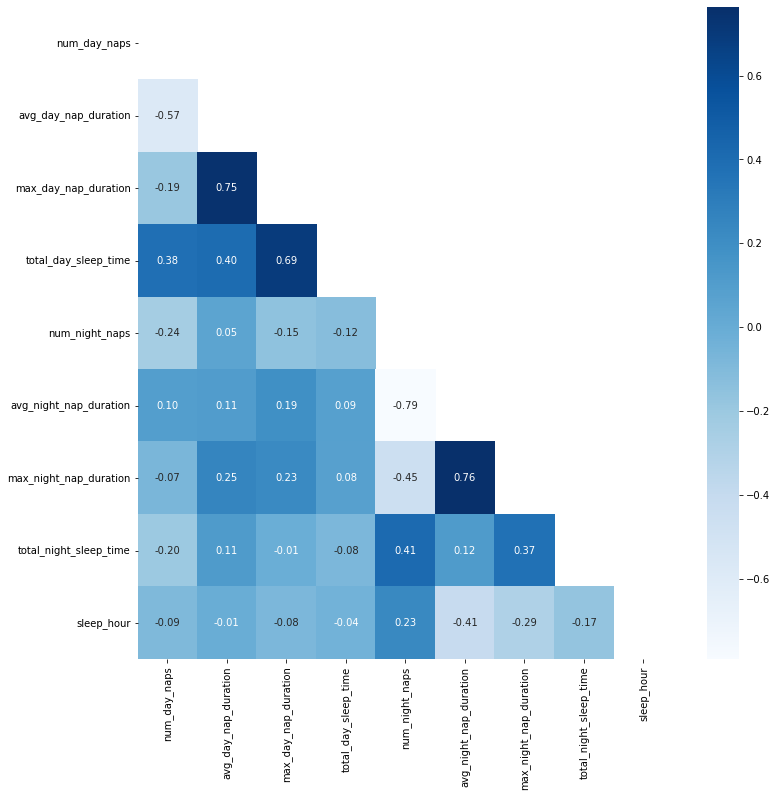

In [30]:
# Keep most reliable data
# compute correlation excluding the months with missing data 

RELIABLE_DATE = date(2022, 9, 1)

# Keep only some features for clarity in notebook (e.g avg and median features are very similar)
features = ['num_day_naps',
       'avg_day_nap_duration',
       'max_day_nap_duration', 'total_day_sleep_time', 'num_night_naps',
       'avg_night_nap_duration',
       'max_night_nap_duration', 'total_night_sleep_time', 'sleep_hour']

activity_df_last = activity_df[activity_df["date"] > RELIABLE_DATE][features]                                             

corr_matrix = activity_df_last.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", mask=mask, fmt=".2f")
plt.show()

Correlation is quite low for all day versus night features but a bit higher for max night nap duration with average daily nap duration(0.25) and max daily nap duration (0.26). Although the signal is quite weak there is some compared to other features.

There is also some negative correlation between bedtime and avg night nap duration (-0.39) and max night nap duration (-0.28) which would indicate that an earlier sleep time for our baby sometimes leads in longer night sleep sessions. 

This is somewhat interesting since this is described in Galland et al.'s review work. However in our case it's hard to know if this correlation also implies causation since his late bedtimes often occurred in his first months when his sleep was not very consolidated.

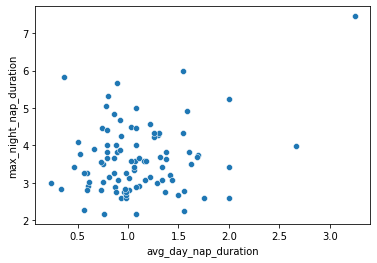

In [31]:
sns.scatterplot(data=activity_df_last, x="avg_day_nap_duration", y="max_night_nap_duration")

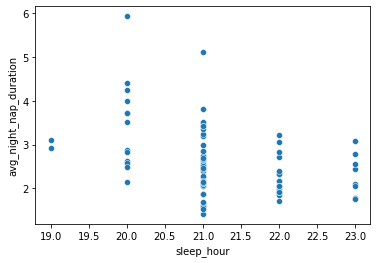

In [32]:
sns.scatterplot(data=activity_df_last, x="sleep_hour", y="avg_night_nap_duration")

### Total sleep duration

#### Total sleep duration by date

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


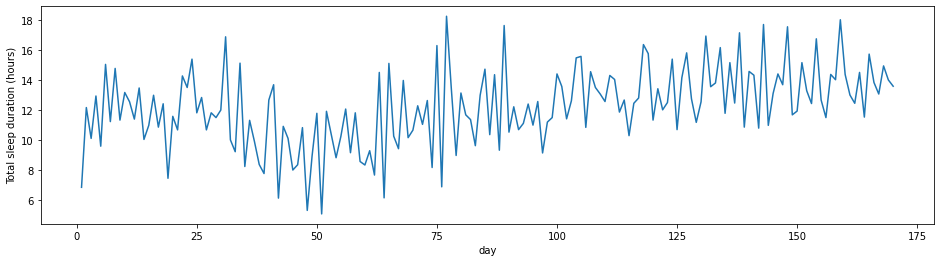

In [33]:
plt.figure(figsize=(16,4))
sns.lineplot(sleep_by_date.day, sleep_by_date.total_sleep_time)
plt.ylabel("Total sleep duration (hours)")
plt.show()

There is a regression around the 2nd and 3rd months. We can also see a lot of variability there, with some days sleeping 8 hours and the next day sleeping 14.

With time, the variability gets reduced.

#### Total sleep duration by week

Group by date. After aggregation, the mean sleep duration is plotted as a line and the shadow represents the confidence interval of the estimate.

This video nicely explains how Seaborn computes the confidence intervals. https://www.youtube.com/watch?v=CMRVEKf9jWA

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


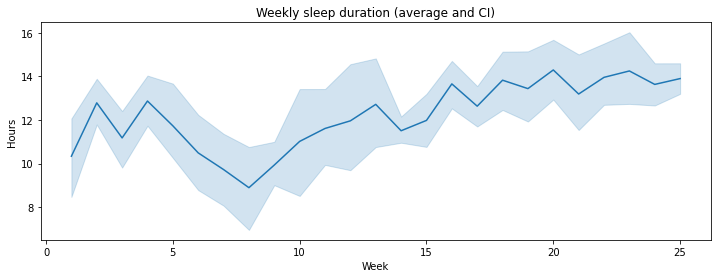

In [34]:
sleep_by_week = sleep_df.groupby(["date", "week", "month"])["durationInHours"].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(sleep_by_week["week"], sleep_by_week["durationInHours"])
plt.title("Weekly sleep duration (average and CI)")
plt.xlabel("Week")
plt.ylabel("Hours")
plt.show()

#### Total sleep duration by month

In [35]:
month_total_hours_df = pd.DataFrame(sleep_df.groupby(["month"])["durationInHours"].agg(["mean", "median", "sum"])).reset_index().sort_values("month") #, ascending=False)
month_total_hours_df

,month,mean,median,sum
0,1,2.119694,2.083333,188.652776
1,2,2.311757,2.416667,344.451796
2,3,2.221170,2.250000,328.733173
3,4,1.705932,1.683333,368.481283
4,5,1.823459,1.666667,415.748709
5,6,2.081168,2.000000,416.233510
6,7,2.263889,2.100000,13.583333


#### Total sleep hours at night (by week)

Luckily for us, the amount of sleep at night has increased in the last weeks. 

We can consider the amount of night wake ups as a signal of quality and thus we can also see an increase in sleep quality over time.

In [36]:
night_sleep_by_week = night_sleep_df.groupby(["date", "week", "month"])["durationInHours"].sum().reset_index()
night_sleep_by_week = night_sleep_by_week.rename({'durationInHours': 'night_hours'}, axis=1)
night_sleep_by_week.head()


,date,week,month,night_hours
0,2022-06-15,1,1,4.166667
1,2022-06-16,1,1,9.500000
2,2022-06-17,1,1,6.800000
3,2022-06-18,1,1,9.900228
4,2022-06-19,1,1,5.000000


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


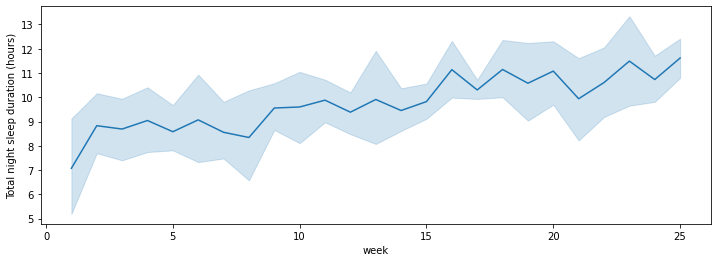

In [37]:
plt.figure(figsize=(12,4))
sns.lineplot(night_sleep_by_week["week"], night_sleep_by_week["night_hours"])
plt.ylabel("Total night sleep duration (hours)")
plt.show()

We can also sum the values instead of using the mean (with `estimator='sum'`).

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


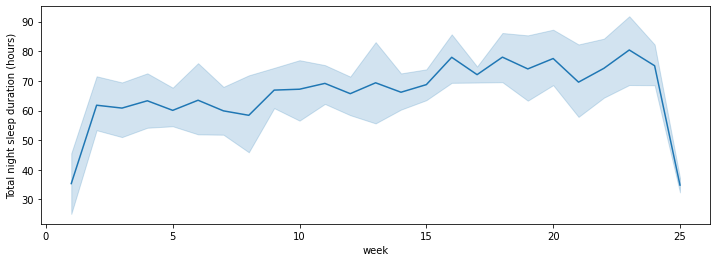

In [38]:
plt.figure(figsize=(12,4))
sns.lineplot(night_sleep_by_week["week"], night_sleep_by_week["night_hours"], estimator='sum')
plt.ylabel("Total night sleep duration (hours)")
plt.show()

#### Night sleep duration vs day sleep duration

Shaded weeks represent weeks with missing data.

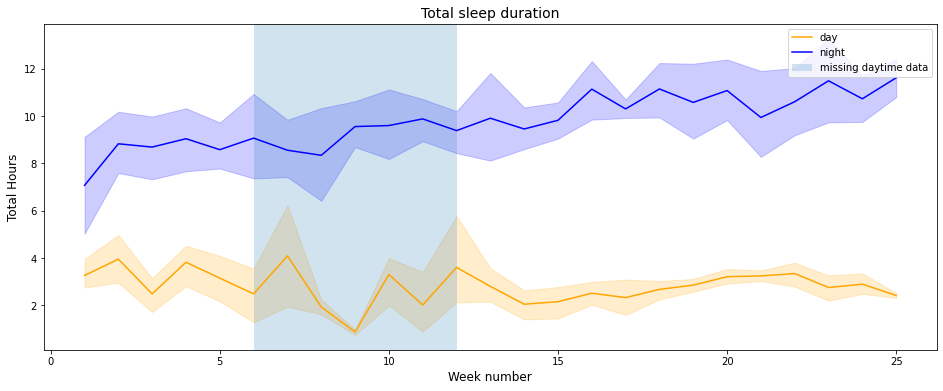

In [39]:
day_sleep_by_week = day_sleep_df.groupby(["date", "week", "month"])["durationInHours"].sum().reset_index()
day_sleep_by_week = day_sleep_by_week.rename({'durationInHours': 'day_hours'}, axis=1)

plt.figure(figsize=(16,6))
sns.lineplot(x=day_sleep_by_week["week"], y=day_sleep_by_week["day_hours"], label="day", color="orange")
sns.lineplot(x=night_sleep_by_week["week"], y=night_sleep_by_week["night_hours"], label="night", color="blue")
plt.axvspan(xmin=6, xmax=12, linestyle='--', label="missing daytime data", alpha=0.2)
plt.title("Total sleep duration", fontsize=14)
plt.xlabel("Week number", fontsize=12)
plt.ylabel("Total Hours", fontsize=12)
plt.legend()
plt.show()

### Sleep session duration

#### Session duration over time (night vs day)

In [40]:
# first day is when he was born (e.g. 140)
first_day = min_date.dayofyear

sleep_df["day"] = df["startTime"].apply(lambda d: (d.dayofyear - first_day + 1) if d is not None else None)
sleep_df[["date", "day"]].head()

<ipython-input-40-ea6649c381bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df["day"] = df["startTime"].apply(lambda d: (d.dayofyear - first_day + 1) if d is not None else None)


,date,day
0,2022-06-15,1
11,2022-06-15,1
12,2022-06-15,1
14,2022-06-16,2
21,2022-06-16,2


[]

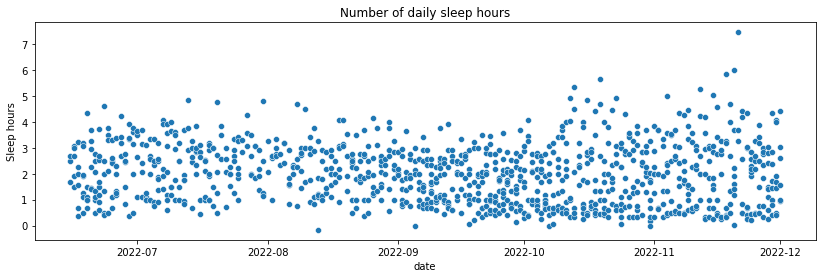

In [41]:
plt.figure(figsize=(14,4))
sns.scatterplot(data=sleep_df, x="date", y="durationInHours")
plt.title("Number of daily sleep hours")
plt.ylabel("Sleep hours")
plt.plot()

It is hard to see any pattern in this data besides that he is taking more and longer sleep sessions during the last weeks. 

However, by using `hue` on the time of day below we see something interesting. When the baby was born he would sleep similarly during day or night, but over time the baby has learnt to distinguish between night and day and most of long naps are now during the night. Yei! Good news for the parents! :)

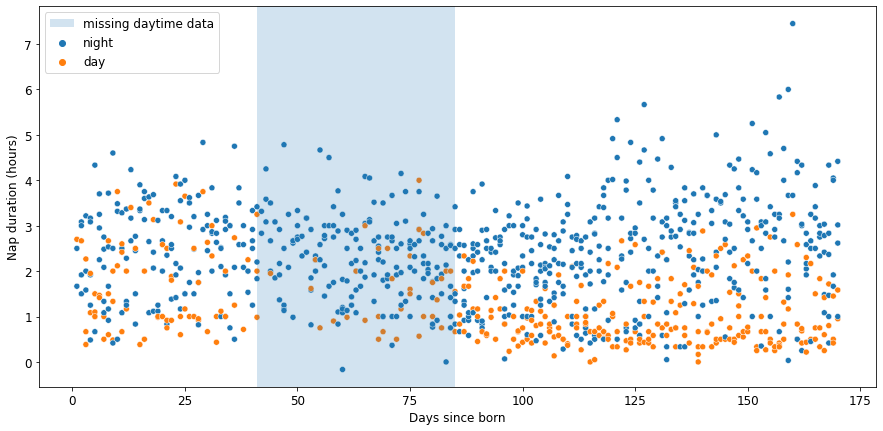

In [42]:
plt.figure(figsize=(15,7))

# palette_colors = {"night": "blue", "day": "orange"}

sns.scatterplot(data=sleep_df, x="day", y="durationInHours", 
                hue="timeOfDay") #, palette=palette_colors) 
plt.axvspan(xmin=41, xmax=85, linestyle='--', label="missing daytime data", alpha=0.2)
plt.xlabel("Days since born", fontsize=12)
plt.ylabel("Nap duration (hours)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Is there a trend on the sleep session duration?

Is there still hope for us parents? Is there a trend towards more or less sleep? To see this I've used `regplot`. 

Need to add a column for the date as a number as it will try to do some regression.

In [43]:
sleep_total_day_hours = sleep_df[["date", "durationInHours"]]
sleep_total_day_hours = sleep_total_day_hours.groupby("date").agg(total_day_hours=('durationInHours', 'sum')).reset_index()
sleep_total_day_hours["timestamp"] = sleep_total_day_hours["date"].apply(lambda d: datetime(d.year, d.month, d.day).timestamp())
sleep_total_day_hours = sleep_total_day_hours.sort_values("timestamp")
sleep_total_day_hours.head()

,date,total_day_hours,timestamp
0,2022-06-15,6.866766,1.655251e+09
1,2022-06-16,12.166667,1.655338e+09
2,2022-06-17,10.117115,1.655424e+09
3,2022-06-18,12.933586,1.655510e+09
4,2022-06-19,9.600000,1.655597e+09


[]

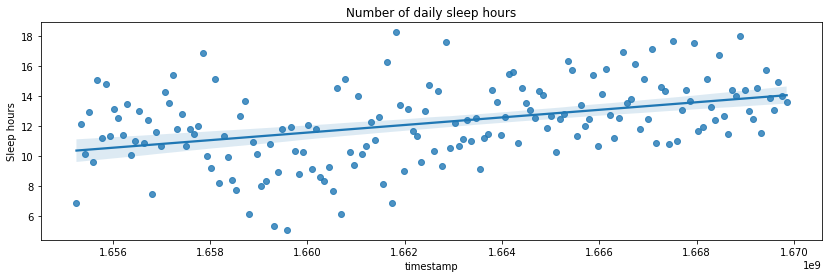

In [44]:
plt.figure(figsize=(14,4))
ax = sns.regplot(data=sleep_total_day_hours, x="timestamp", y="total_day_hours")
# ax.set_xticks(dates)
plt.title("Number of daily sleep hours")
plt.ylabel("Sleep hours")
plt.plot()


Although we still have a lot of variability in his sleep, luckily the trend seems to go upwards so which shows the baby is learning how to sleep! 

### Night nap duration and number of wakings

Our sleep quality is a combination of our baby’s night nap duration and number of wakings (this is, the number of naps minus one, as I exclude his last waking in the morning).

#### Night nap duration summary

Use a violin plot instead of box plot as we can better see the distribution of the data.





Text(0.5, 0, 'Month')

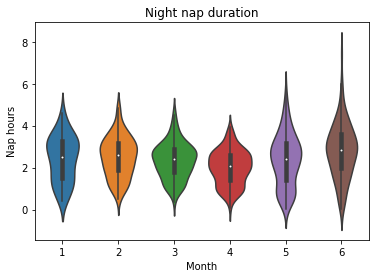

In [45]:
night_sleep_df = night_sleep_df[night_sleep_df["durationInHours"] > 0]

sns.violinplot(data=night_sleep_df, x="month", y="durationInHours")
plt.title("Night nap duration", fontsize=12)
plt.ylabel("Nap hours")
plt.xlabel("Month")

#### Number of night wakings

**How many times does he wake up at night?**

Although many sources say that after the 4 month babies can sleep 7 straight hours our baby is still waking up several times during the night for feeding or just comfort. 

Normally we put him to bed around 8-9pm and he wakes up around 8.30-9am (that is, after some times waking up).

There are nights when he feeds and inmediately goes back to sleep whereas others he becomes active and can spend 1 hour or more awake before going back to sleep. Also, we have nights where the sleep time is really short (sadly for us sometimes he wakes up every hour!) and others where he can sleep for 5h straight.

I wanted to know what patterns he has been following. For this I want to see the number of times he wakes up and also how long is he awake for.



We can then see that on the first months most nights he would do 3 naps (i.e. wake up twice) whereas in the 3rd month the mode is around 4.

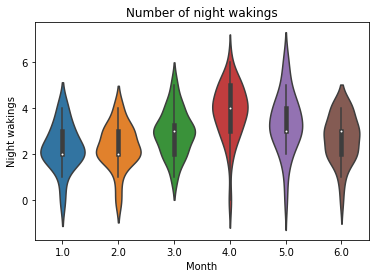

In [46]:
activity_df["num_wakings"] = activity_df["num_night_naps"] - 1

sns.violinplot(data=activity_df, x="month", y="num_wakings")
plt.title("Number of night wakings", fontsize=12)
plt.ylabel("Night wakings")
plt.xlabel("Month")
plt.show()

The following plot shows the confidence intervals since we have multiple data point for each month.

It can be seen that the baby started a sleep regression in the 3th month. This coincided with a development milestone in which he learnt to turn from his back to his tummy. During those days we were proud but also tired parents 😅.

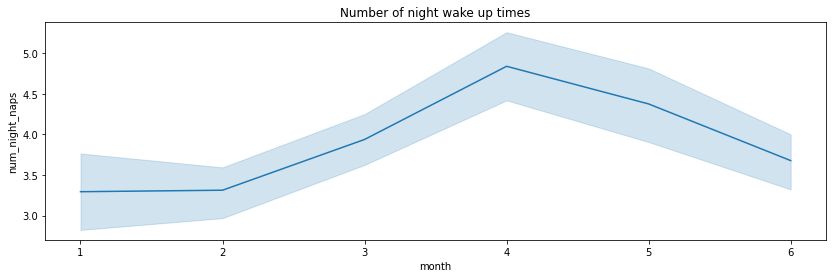

In [47]:
plt.figure(figsize=(14,4))
sns.lineplot(data=activity_df, x="month", y="num_night_naps") #, ci=None)
plt.title("Number of night wake up times")
plt.show()


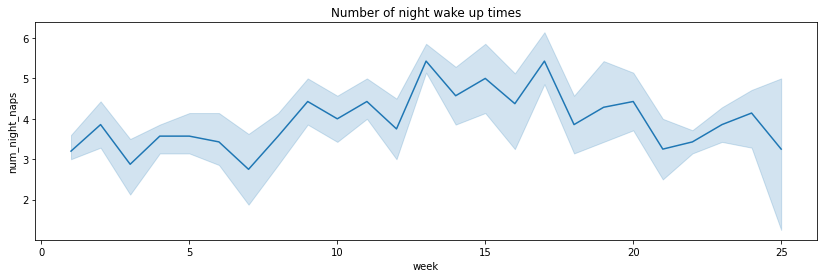

In [48]:
plt.figure(figsize=(14,4))
sns.lineplot(data=activity_df, x="week", y="num_night_naps") #, ci=None)
plt.title("Number of night wake up times")
plt.show()

#### Average nap duration vs number of wakings

Use strip plot instead of scatter to better see all the data points.

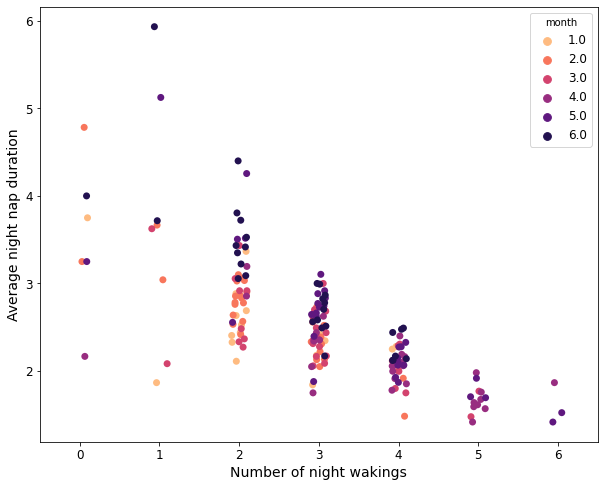

In [49]:
plt.figure(figsize=(10,8))
sns.stripplot(data=activity_df, x="num_wakings", y="avg_night_nap_duration", size=7, hue="month", palette="magma_r")
plt.xlabel("Number of night wakings", fontsize=14)
plt.ylabel("Average night nap duration", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title="month")
plt.show()

It is hard to see some data points as they overlap. To avoid this use a swarm plot instead. 

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


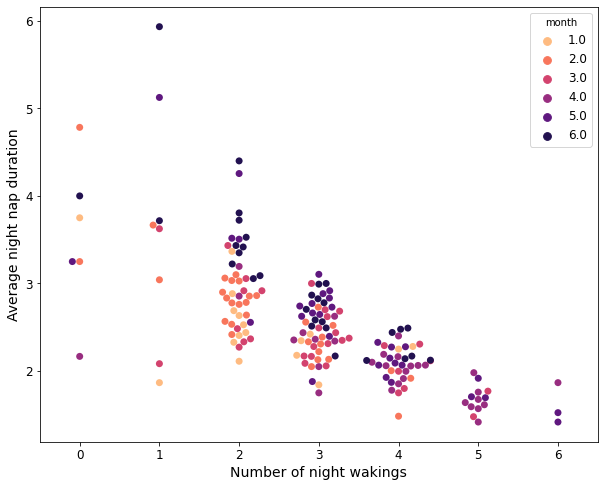

In [50]:
plt.figure(figsize=(10,8))
sns.swarmplot(data=activity_df, x="num_wakings", y="avg_night_nap_duration", size=7, hue="month", palette="magma_r")
plt.xlabel("Number of night wakings", fontsize=14)
plt.ylabel("Average night nap duration", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title="month")
plt.show()

### Awake time and max nap time

#### Awake time

In [51]:
## A night starts at 20:00 on date D and ends at 10:00 on date D+1

start_date = sleep_df["date"].min() + timedelta(days=1)
end_date = sleep_df["date"].max() - timedelta(days=1)

print(start_date, " ", end_date)

2022-06-16   2022-11-30


In [52]:
dt = date(2022, 6, 18)

def night_records(df, dt):
  next_dt = dt + timedelta(days=1)

  night_start = ((df["date"] == dt) & (df["hour"] >= 20))
  night_end = ((df["date"] == next_dt) & (df["hour"] <= 10))
  return df.loc[night_start | night_end]

nr = night_records(night_sleep_df, dt).sort_values(["startTime"])

nr

,type,date,day,startTime,endTime,duration,durationInMins,durationInHours,month,week,hour,hourEnd,decimalHour,timeOfDay,nightDate
60,sleep,2022-06-18,4,2022-06-18 21:30:10+02:00,2022-06-18 21:59:10.339000+02:00,0 days 00:29:00.339000,29.00565,0.483428,1,1,21,21,21.5,night,2022-06-18
81,sleep,2022-06-18,4,2022-06-18 23:25:40+02:00,2022-06-19 02:30:40+02:00,0 days 03:05:00,185.00000,3.083333,1,1,23,2,23.4,night,2022-06-18
65,sleep,2022-06-19,5,2022-06-19 03:50:30+02:00,2022-06-19 08:10:30+02:00,0 days 04:20:00,260.00000,4.333333,1,1,3,8,3.8,night,2022-06-18


In [53]:
def night_awake_times(night_records):
  '''
    Return array with duration of all awake times in minutes
  '''
  awake_durations = []

  night_records = night_records.sort_values(["startTime"])

  startTimes = night_records["startTime"].tolist()
  endTimes = night_records["endTime"].tolist()
  for i in range(len(endTimes) - 1):
    diff = startTimes[i+1] - endTimes[i]
    # print(startTimes[i+1], " - " ,endTimes[i])
    diff_in_mins = diff.total_seconds() / 60
    awake_durations.append(diff_in_mins)

  return awake_durations

awake_durations = night_awake_times(nr)
print(len(awake_durations))
awake_durations

2


[86.49435, 79.83333333333333]

In [54]:
naps_info = []

for dt in pd.date_range(start=start_date, end=end_date):
  night_entries = night_records(night_sleep_df, dt).sort_values(["startTime"])
  # print(night_entries.iloc[0]["durationInHours"])
  max_nap_loc = night_entries["durationInHours"].argmax()
  max_nap_hour = night_entries.iloc[max_nap_loc]["startTime"]
  awake_times = night_awake_times(night_entries)
  total_awake_time = sum(awake_times)
  num_awake_times = len(awake_times)
  if len(awake_times) > 0:
    mean_awake_time = total_awake_time / num_awake_times
    min_awake_time = min(awake_times)
    max_awake_time = max(awake_times)
  else:
    mean_awake_time = 0
    min_awake_time = 0
    max_awake_time = 0
  naps_info.append([dt, len(night_entries), 
                    night_entries["durationInHours"].max(),
                    max_nap_hour,
                    max_nap_loc + 1,
                    num_awake_times,
                    total_awake_time,
                    mean_awake_time,
                    min_awake_time,
                    max_awake_time])

night_naps_df = pd.DataFrame(naps_info, columns=['date', 'num_wakeups', 'max_nap_duration', 'max_nap_hour', 'max_nap_number',
                                                 'num_awake_times', 'total_awake_time', 'mean_awake_time', 
                                                 'min_awake_time', 'max_awake_time'])

night_naps_df["month"] = night_naps_df["date"].apply(lambda d: (d.month - min_date.month + 1) if d is not None else None)
night_naps_df["day"] = night_naps_df["date"].apply(lambda d: (d.dayofyear - min_date.dayofyear + 1) if d is not None else None)


night_naps_df.head(2)

,date,num_wakeups,max_nap_duration,max_nap_hour,max_nap_number,num_awake_times,total_awake_time,mean_awake_time,min_awake_time,max_awake_time,month,day
0,2022-06-16,3,3.216667,2022-06-17 00:07:10+02:00,1,2,140.566667,70.283333,30.716667,109.850000,1,2
1,2022-06-17,3,3.166800,2022-06-18 02:02:26+02:00,1,2,53.025317,26.512658,20.233333,32.791983,1,3


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


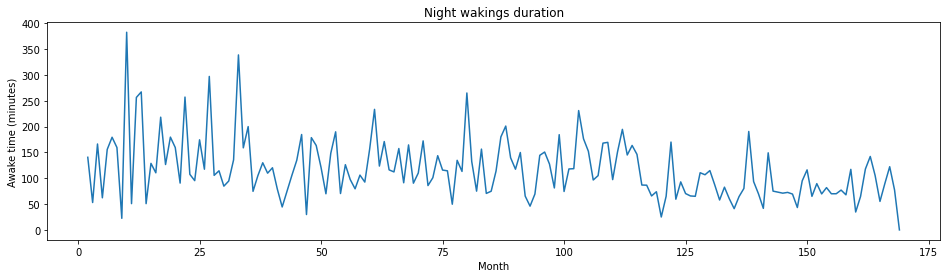

In [55]:
plt.figure(figsize=(16,4))
sns.lineplot(night_naps_df["day"], night_naps_df["total_awake_time"])
plt.title("Night wakings duration", fontsize=12)
plt.ylabel("Awake time (minutes)")
plt.xlabel("Month")
plt.show()

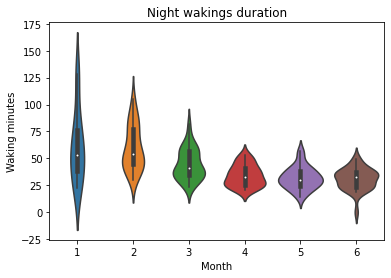

In [56]:
sns.violinplot(data=night_naps_df, x="month", y="mean_awake_time")
plt.title("Night wakings duration", fontsize=12)
plt.ylabel("Waking minutes")
plt.xlabel("Month")
plt.show()

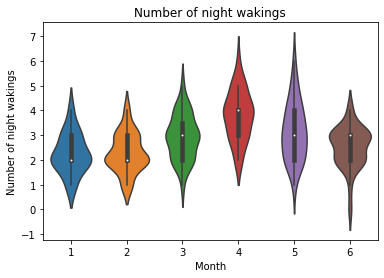

In [57]:
sns.violinplot(data=night_naps_df, x="month", y="num_awake_times")
plt.title("Number of night wakings", fontsize=12)
plt.ylabel("Number of night wakings")
plt.xlabel("Month")
plt.show()



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


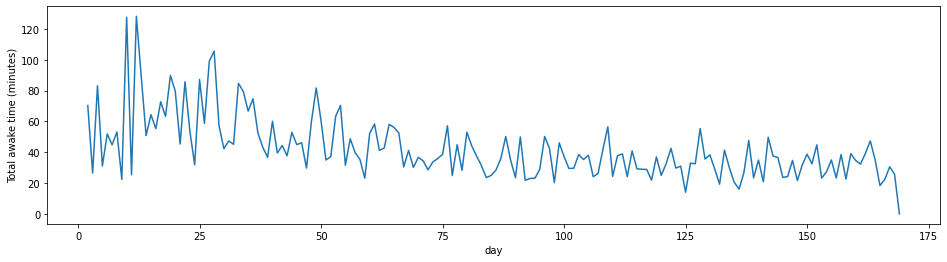

In [58]:
plt.figure(figsize=(16,4))
sns.lineplot(night_naps_df["day"], night_naps_df["mean_awake_time"])
plt.ylabel("Total awake time (minutes)")
plt.show()

Nice decreasing trend.

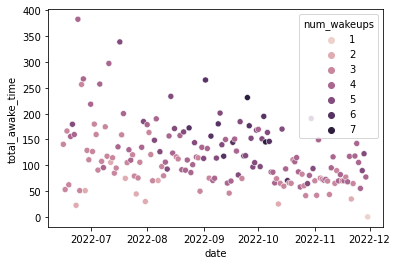

In [59]:
sns.scatterplot(data=night_naps_df, x="date", y="total_awake_time", hue="num_wakeups")

#### Longest night sleep session

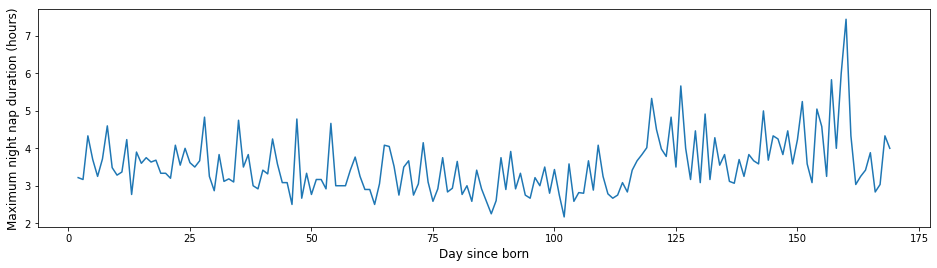

In [60]:
plt.figure(figsize=(16,4))
# sns.lineplot(data=night_naps_df, x="date", y="max_nap_duration")
sns.lineplot(data=night_naps_df, x="day", y="max_nap_duration")
plt.xlabel("Day since born", fontsize=12)
plt.ylabel("Maximum night nap duration (hours)", fontsize=12)
plt.show()

#### Max night sleep session per month

In [61]:
max_month_nap = night_naps_df.groupby(["month"])["max_nap_duration"].agg(['max', 'idxmax'])
max_month_nap

,max,idxmax
month,,
1,4.600000,6
2,4.833333,26
3,4.666667,52
4,3.916667,89
5,5.666667,124
6,7.449984,158


In [62]:
max_month_nap["max_nap_date"] = night_naps_df.iloc[max_month_nap["idxmax"].to_list()]["date"].to_list()
max_month_nap = max_month_nap.reset_index()
max_month_nap

,month,max,idxmax,max_nap_date
0,1,4.600000,6,2022-06-22
1,2,4.833333,26,2022-07-12
2,3,4.666667,52,2022-08-07
3,4,3.916667,89,2022-09-13
4,5,5.666667,124,2022-10-18
5,6,7.449984,158,2022-11-21


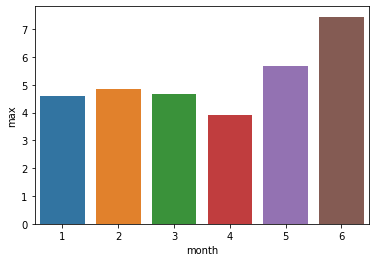

In [63]:
sns.barplot(data=max_month_nap, x="month", y="max")

#### Longest night session rank

When are his longest sleep sessions?

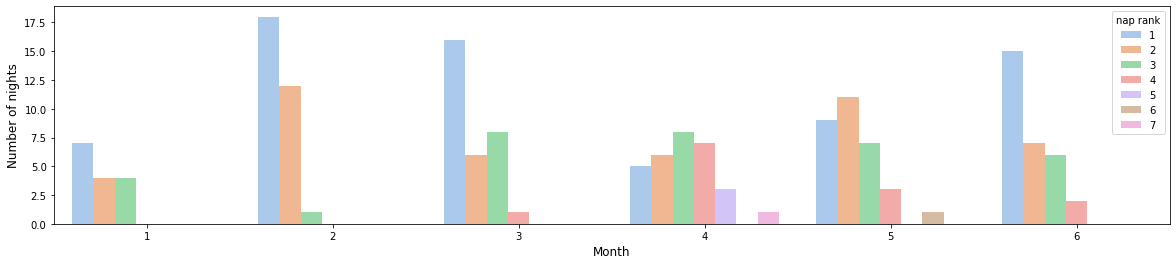

In [64]:
plt.figure(figsize=(20,4))
sns.countplot(data=night_naps_df, x="month", hue="max_nap_number", palette="pastel")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of nights", fontsize=12)
plt.legend(loc="upper right", title="nap rank")
plt.show()

### Bedtime

*At what time does he go to sleep every day?*

We do not enforce any sleeping method, we just put him down to sleep when we see tiredness signals. It is then interesting to see how he has naturally acquired a bedtime hour around 8-8.30pm.

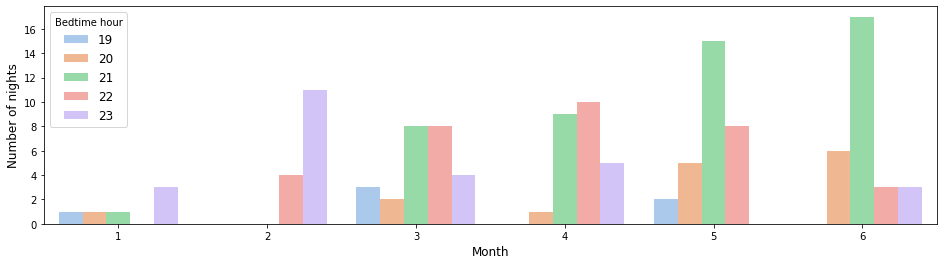

In [65]:
# exclude December
sleep_time = sleep_time[sleep_time["date"] < date(2022,12,1)]

plt.figure(figsize=(16,4))
sns.countplot(data=sleep_time, x="month", hue="sleep_hour", palette="pastel")
plt.ylabel("Number of nights", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.legend(title='Bedtime hour', loc='upper left', fontsize=12)
plt.show()